# Power consumption evaluation

## 1. Load libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

import os
import sys
import glob

from matplotlib import rc
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.patches import Ellipse

from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Create linestyles for black and white plots
ls = ["-","--","-.",":"]
clrs = ["k"]

linestyles = list()
for l in ls:
    for c in clrs:
        linestyles.append(l+c)
            
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7.0, 4.0),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## 2. Create functions for data processing and plotting

In [2]:
def compute_stats(datasets, confidence=0.95):
    import scipy.stats
    vpp = 1
    df_conv = datasets['df_conv']
    df_sol = datasets['df_sol']

    df_freq = np.sort(df_conv.Freq.unique())
    df_lp_freq = np.sort(df_sol.loc[(df_sol.Vpp == vpp)].Freq.unique())

    mean_current = np.zeros((np.max(df_freq), 2))
    err_current = np.zeros((np.max(df_lp_freq), 2))
    mean_power = np.zeros((np.max(df_freq), 2))
    err_power = np.zeros((np.max(df_lp_freq), 2))

    for d in range(0, mean_current.shape[1]):
        for f in df_freq:
            current = df_conv.loc[(df_conv.Freq == f)]['Main(mA)'].values
            if current.size == 0: continue
            voltage = df_conv.loc[(df_conv.Freq == f)]['Main Voltage(V)'].values
            if voltage.size == 0: continue
            power = np.multiply(current, voltage)

            mean_current[f-1,0],se = np.mean(current), scipy.stats.sem(current)
            mean_power[f-1,0],se = np.mean(power), scipy.stats.sem(power)
            err_current[f-1,0] = (se * scipy.stats.t.ppf((1 + confidence) / 2., len(current)-1))
            err_power[f-1,0] = (se * scipy.stats.t.ppf((1 + confidence) / 2., len(power)-1))

            current = df_sol.loc[(df_sol.Vpp == vpp) & (df_sol.Freq == f)]['Main(mA)'].values

            if current.size == 0: continue
            voltage = df_sol.loc[(df_sol.Vpp == vpp) & (df_sol.Freq == f)]['Main Voltage(V)'].values
            if voltage.size == 0: continue
            power = np.multiply(current, voltage)

            mean_current[f-1,1],se = np.mean(current), scipy.stats.sem(current)
            mean_power[f-1,1],se = np.mean(power), scipy.stats.sem(power)
            err_current[f-1,1] = (se * scipy.stats.t.ppf((1 + confidence) / 2., len(current)-1))
            err_power[f-1,1] = (se * scipy.stats.t.ppf((1 + confidence) / 2., len(power)-1))
    dic = {'freq': df_freq,
           'mean_current': mean_current,
           'err_current': err_current,
           'mean_power': mean_power,
           'err_power': err_power}
    return dic

In [3]:
def sort_dataset_with_duration(datasets, duration=None, vpp = 1):

    if duration == None:
        samples = int(5000 * 5)
    elif duration > 5 or duration <= 0:
        return None
    else:
        samples = int(5000 * duration)

    df_conv = datasets['df_conv']
    df_sol = datasets['df_sol']

    df_conv_freq = np.sort(df_conv.Freq.unique())
    df_sol_freq = np.sort(df_sol.loc[(df_sol.Vpp == vpp)].Freq.unique())

    length = samples * len(df_conv_freq)
    np_conv_freq_sorted = np.zeros((length, 3))
    np_sol_freq_sorted = np.zeros((length, 3))

    i = 0
    for f in df_conv_freq:
        # Conventional solution
        timestamp = df_conv.loc[(df_conv.Freq == f)]['Time(ms)'].iloc[:samples].values
        current = df_conv.loc[(df_conv.Freq == f)]['Main(mA)'].iloc[:samples].values
        voltage = df_conv.loc[(df_conv.Freq == f)]['Main Voltage(V)'].iloc[:samples].values

        ix0 = i * len(timestamp)
        ixe = (i + 1) * len(timestamp)

        if i > 0: timestamp = timestamp + np_conv_freq_sorted[ix0-1, 0]

        np_conv_freq_sorted[ix0:ixe, 0] = timestamp
        np_conv_freq_sorted[ix0:ixe, 1] = current
        np_conv_freq_sorted[ix0:ixe, 2] = voltage
        i += 1

    i = 0
    for f in df_sol_freq:
        # Our solution
        timestamp = df_sol.loc[(df_sol.Vpp == vpp) & (df_sol.Freq == f)]['Time(ms)'].iloc[:samples].values
        current = df_sol.loc[(df_sol.Vpp == vpp) & (df_sol.Freq == f)]['Main(mA)'].iloc[:samples].values
        voltage = df_sol.loc[(df_sol.Vpp == vpp) & (df_sol.Freq == f)]['Main Voltage(V)'].iloc[:samples].values

        ix0 = i * len(timestamp)
        ixe = (i + 1) * len(timestamp)

        if i > 0:
            timestamp = timestamp + np_sol_freq_sorted[ix0-1, 0]

        np_sol_freq_sorted[ix0:ixe, 0] = timestamp
        np_sol_freq_sorted[ix0:ixe, 1] = current
        np_sol_freq_sorted[ix0:ixe, 2] = voltage

        i+=1
    dic = {'freq': df_conv_freq, 'np_conv': np_conv_freq_sorted, 'np_sol': np_sol_freq_sorted}
    return dic

In [4]:
def plot_sorted_dataset(dic, power_units=False, savefig=False):
    freq = dic['freq']
    np_conv = dic['np_conv']
    np_sol = dic['np_sol']

    timestamp_conv, timestamp_sol = np_conv[:,0], np_sol[:,0]
    current_conv, current_sol = np_conv[:,1], np_sol[:,1]
    voltage_conv, voltage_sol = np_conv[:,2], np_sol[:,2]

    if power_units == True:
        power_conv = np.multiply(current_conv,voltage_conv)
        power_sol = np.multiply(current_sol,voltage_sol)

    fig = plt.figure(figsize=(6.5, 4))
    ax = fig.add_subplot(111)

    if power_units == False:
        ax.plot(timestamp_sol, current_sol, color=colors['dimgrey'], label='Our solution')
        ax.plot(timestamp_conv, current_conv, color=colors['gray'], label='Conventional method')
    else:
        ax.plot(timestamp_sol, power_sol, color=colors['dimgrey'], label='Our solution')
        ax.plot(timestamp_conv, power_conv, color=colors['gray'], label='Conventional method')

    plt.axvline(x=4.16, ymin = 0.02, ymax = 0.95, color='k', ls='--', lw=1.)
    plt.axvline(x=5.18, ymin = 0.02, ymax = 0.95, color='k', ls='--', lw=1.)
    plt.axvline(x=6.21, ymin = 0.02, ymax = 0.95, color='k', ls='--', lw=1.)
    plt.axvline(x=7.25, ymin = 0.02, ymax = 0.95, color='k', ls='--', lw=1.)

    ax.annotate("",
            xy=(4.16, 20), xycoords='data',
            xytext=(5.18, 20), textcoords='data',
            size=10,
            arrowprops=dict(arrowstyle="<->", fc="0.6",
                            connectionstyle="arc3", lw=1),
            )
    ax.annotate("",
            xy=(5.18, 20), xycoords='data',
            xytext=(6.21, 20), textcoords='data',
            size=10,
            arrowprops=dict(arrowstyle="<->", fc="0.6",
                            connectionstyle="arc3", lw=1),
            )
    ax.annotate("",
            xy=(6.21, 20), xycoords='data',
            xytext=(7.25, 20), textcoords='data',
            size=10,
            arrowprops=dict(arrowstyle="<->", fc="0.6",
                            connectionstyle="arc3", lw=1),
            )
    ax.annotate("",
            xy=(7.25, 20), xycoords='data',
            xytext=(7.9, 20), textcoords='data',
            size=10,
            arrowprops=dict(arrowstyle="->", fc="0.6",
                            connectionstyle="arc3", lw=1),
            )

    ax.annotate("4 Hz",
            xy=(4.5, 22), xycoords='data',
            xytext=(4.5, 22), textcoords='data',
            size=14)
    ax.annotate("5 Hz",
            xy=(5.5, 22), xycoords='data',
            xytext=(5.5, 22), textcoords='data',
            size=14)
    ax.annotate("6 Hz",
            xy=(6.6, 22), xycoords='data',
            xytext=(6.6, 22), textcoords='data',
            size=14)
    ax.annotate("7 Hz",
            xy=(7.5, 22), xycoords='data',
            xytext=(7.5, 22), textcoords='data',
            size=14)
    
    el = Ellipse((2, -1), 0.5, 0.5)
    ax.add_patch(el)
    ann1 = ax.annotate('Conventional method',
        xy=(6.0, 37), xycoords='data',
        xytext=(6.0, 30), textcoords='data',
        size=14, va="center",
        bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec=colors['gray'], lw=2),
        arrowprops=dict(arrowstyle="wedge,tail_width=1.",
            fc=(1.0, 1.0, 1.0), ec=colors['gray'], lw=2,
            patchA=None,
            patchB=el,
            relpos=(0.2, 0.5)))
    
    ann2 = ax.annotate('Our solution',
        xy=(4.8, 7), xycoords='data',
        xytext=(4.8, 14), textcoords='data',
        size=14, va="center",
        bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec=colors['dimgrey'], lw=2),
        arrowprops=dict(arrowstyle="wedge,tail_width=1.",
            fc=(1.0, 1.0, 1.0), ec=colors['dimgrey'], lw=2,
            patchA=None,
            patchB=el,
            relpos=(0.2, 0.5)))

    ax.set_xlabel('Time (s)')
    if power_units == True: ax.set_ylabel('Power (mW)')
    else: ax.set_ylabel('Current (mA)')

    ax.grid(color='gray', linestyle='dotted')
    ax.set_axisbelow(False)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    #ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=1,
    #        borderaxespad=0, frameon=True, prop={'size': 14})

    ax.set_yticks(np.arange(0, 45+1, 5.0))
    if power_units == True: ax.set_ylim([0,45])
    else: ax.set_ylim([0,15])
    ax.set_xlim([4,8])

    fig.tight_layout()

    if savefig == True:
        if not os.path.exists('figures'):
            os.makedirs('figures')
            
        figurename = ''
        if power_units == True:
            figurename += 'figures/figure12a_power.pdf'
        else:
            figurename += 'figures/figure12a_current.pdf'

        plt.savefig(figurename,
            transparent=True, format='pdf', dpi=300, bbox_inches = 'tight',
            pad_inches = 0)

In [5]:
def compute_lifetime(dic, battery_size=1800):
    freq = dic['freq']
    mean_current = dic['mean_current']
    err_current = dic['err_current']
    mean_power = dic['mean_power']
    err_power = dic['err_power']

    mean_conv = mean_current[:,0][mean_current[:,0] != 0]
    mean_sol = mean_current[:,1][mean_current[:,1] != 0]

    life_conv = np.max(battery_size / mean_conv)
    life_sol = np.max(battery_size / mean_sol)

    return [life_conv, life_sol]

In [6]:
def plot_consumption(dic, power_units=False, battery_size=1800, savefig=False):
    freq = dic['freq']
    mean_current = dic['mean_current']
    err_current = dic['err_current']
    mean_power = dic['mean_power']
    err_power = dic['err_power']

    life_conv, life_sol = compute_lifetime(dic, battery_size=battery_size)

    if power_units == True:
        mean_conv = mean_power[:,0][mean_power[:,0] != 0]
        error_conv = err_power[:,0][mean_power[:,0] != 0]
        mean_sol = mean_power[:,1][mean_power[:,1] != 0]
        error_sol = err_power[:,1][mean_power[:,1] != 0]
    else:
        mean_conv = mean_current[:,0][mean_current[:,0] != 0]
        error_conv = err_current[:,0][mean_current[:,0] != 0]
        mean_sol = mean_current[:,1][mean_current[:,1] != 0]
        error_sol = err_current[:,1][mean_current[:,1] != 0]

    # Create blue bars
    fig = plt.figure(figsize=(6.5, 4))
    ax = fig.add_subplot(111)

    c = [colors['saddlebrown'], colors['goldenrod']]
    labels = ['Our solution', 'Conventional method']

    for i,data in enumerate((mean_sol, mean_conv)):
        ax.plot(freq, data, linestyles[i], label=labels[i])
        #ax.fill_between(freq, 0, data, alpha=.4)

    if power_units == True:
        ax.set_ylabel('Power (mW)')
    else:
        ax.set_ylabel('Current (mA)')
    ax.set_xlabel('Frequency (Hz)')

    ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=1,
            borderaxespad=0, frameon=True, prop={'size': 14})

    #xticks_labels = [str(l) for l in range(1,max(freq)+1,2)]
    #plt.xticks([r for r in range(1,max(freq)+1,2)], xticks_labels)
    xticks_labels = [str(l) for l in range(1,max(freq)+1,1)]
    plt.xticks([r for r in range(1,max(freq)+1,1)], xticks_labels)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.grid(color='gray', linestyle='dotted')
    ax.set_axisbelow(False)

    ax.set_yticks(np.arange(0, 45+1, 5.0))
    ax.set_ylim([0,45])
    ax.set_xlim([1,19])

    el = Ellipse((2, -1), 0.5, 0.5)
    ax.add_patch(el)

    ann1 = ax.annotate('~%d days with a\n%d mAh battery' % (life_conv//24, battery_size),
        xy=(freq[2], mean_conv[2]), xycoords='data',
        xytext=(freq[2], mean_conv[2]-8), textcoords='data',
        size=14, va="center",
        bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec=colors['gray'], lw=2),
        arrowprops=dict(arrowstyle="wedge,tail_width=1.",
            fc=(1.0, 1.0, 1.0), ec=colors['gray'], lw=2,
            patchA=None,
            patchB=el,
            relpos=(0.2, 0.5)))

    ann2 = ax.annotate('~%d days with a\n%d mAh battery' % (life_sol//24, battery_size),
        xy=(freq[2], mean_sol[2]), xycoords='data',
        xytext=(freq[2], mean_sol[2]+8), textcoords='data',
        size=14, va="center",
        bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec=colors['dimgrey'], lw=2),
        arrowprops=dict(arrowstyle="wedge,tail_width=1.",
            fc=(1.0, 1.0, 1.0), ec=colors['dimgrey'], lw=2,
            patchA=None,
            patchB=el,
            relpos=(0.2, 0.5)))

    ax.annotate("",
            xy=(freq[10], mean_conv[10]+1.), xycoords='data',
            xytext=(freq[10], mean_sol[10]-1.), textcoords='data',
            size=20,
            arrowprops=dict(arrowstyle="<->", fc="0.6",
                            connectionstyle="arc3", lw=2),
            )

    ax.annotate("~%dx difference in\npower consumption" % ( life_sol//life_conv ),
            xy=(freq[10]+.3, 0.5 * (mean_conv[10] + mean_sol[10])), xycoords='data',
            xytext=(freq[10]+.3, 0.5 * (mean_conv[10] + mean_sol[10])), textcoords='data',
            size=14)

    fig.tight_layout()
    if savefig == True:
        if not os.path.exists('figures'):
            os.makedirs('figures')
            
        figurename = ''
        if power_units == True:
            figurename += 'figures/figure12b-power.pdf'
        else:
            figurename += 'figures/figure12b-current.pdf'

        plt.savefig(figurename,
            transparent=True, format='pdf', dpi=300, bbox_inches = 'tight',
            pad_inches = 0)

    plt.show()

## 3. Compute and plot results

In [7]:
# Load data
# Load power measurements for the conventional approach
df_conv = pd.read_csv('data/power-monitor-conventional.csv')
# Load power measurements for our solution
df_sol = pd.read_csv('data/power-monitor-solution.csv')

In [8]:
df_conv.head()

Time(ms)   Main(mA)  Main Voltage(V)  Vpp  Freq  ExpDatetime
0  0.028768  12.030933          3.28400    2    10     20181107
1  0.029090  12.019267          3.28275    2    10     20181107
2  0.029347  12.029138          3.28325    2    10     20181107
3  0.029347  11.543672          3.28550    2    10     20181107
4  0.029585  11.405481          3.28150    2    10     20181107

In [9]:
df_sol.head()

Time(ms)  Main(mA)  Main Voltage(V)  Vpp  Freq  ExpDatetime
0  0.029261  1.297670          3.28325  0.5    10     20181107
1  0.029656  1.257286          3.28175  0.5    10     20181107
2  0.029656  1.359592          3.28250  0.5    10     20181107
3  0.030773  1.320106          3.28475  0.5    10     20181107
4  0.030773  1.376643          3.28375  0.5    10     20181107

In [10]:
datasets = {"df_conv": df_conv, "df_sol": df_sol}
dict_current = compute_stats(datasets)

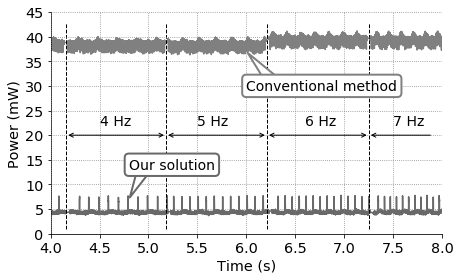

In [11]:
plot_sorted_dataset(sort_dataset_with_duration(datasets, duration=1),
    power_units=True, savefig=True)

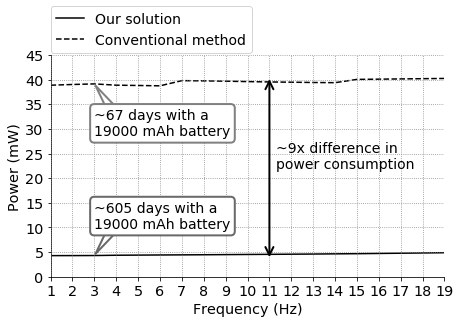

In [12]:
plot_consumption(dict_current, power_units=True, battery_size=19000, savefig=True)